# 1.27a: Thimble 3 Epoch Detection

**Purpose:** Verify that the three core epochs (Sneeze, Deceleration, Fimbulwinter) exist in Thimble 3 data.

Thimble 3 uses a different training loop and records everything in bfloat16. Before we analyze momentum/variance dynamics, we need to confirm the epoch structure survived these changes.

## Detection Method

Following 1.24b's approach:

1. **The Sneeze**: t=0 → peak velocity
2. **Deceleration**: peak velocity → >90% frozen  
3. **Fimbulwinter**: >90% frozen → t=1000

Optional features:
- **Inhale**: Local minimum in radius during t=0-20
- **Re-expansion**: Acceleration sign change during Deceleration

## Parameters

In [37]:
# Data paths
DATA_PATH = "../tensors/Thimble/thimble_3.safetensors"
MASK_PATH = "../tensors/Flannel/live_dead_tokens.safetensors"

# Detection parameters
EARLY_WINDOW = 20  # Window for detecting Inhale
FREEZE_THRESHOLD = 0.9  # Fraction frozen for Fimbulwinter onset

# Plot settings
DPI = 200
FIGSIZE = (12, 6)

print("✓ Parameters set")

✓ Parameters set


## Imports

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

print("✓ Imports complete")

✓ Imports complete


## Device Detection

In [39]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [40]:
print("Loading Thimble 3 data...\n")

data = load_file(DATA_PATH)

# Extract W matrix (recorded in bfloat16, convert to float32 for computation)
W = data['W'].float()  # (1001, 10000, 64)

# Load token masks
mask_data = load_file(MASK_PATH)
dead_mask = mask_data['dead_mask'].bool()
live_mask = mask_data['live_mask'].bool()

print(f"W shape: {tuple(W.shape)}")
print(f"Dead tokens: {dead_mask.sum().item()}")
print(f"\n✓ Data loaded")

Loading Thimble 3 data...

W shape: (1001, 10000, 64)
Dead tokens: 3699

✓ Data loaded


## Compute Kinematic Quantities

In [41]:
print("Computing radius, velocity, acceleration...\n")

# Extract dead tokens
W_dead = W[:, dead_mask, :]  # (1001, n_dead, 64)

# Radius from origin
radii = torch.norm(W_dead, dim=2)  # (1001, n_dead)
mean_radius = radii.mean(dim=1)  # (1001,)

# Velocity (first derivative)
velocity = torch.diff(mean_radius)  # (1000,)

# Acceleration (second derivative)
acceleration = torch.diff(velocity)  # (999,)

# Frozen fraction
displacements = torch.norm(W_dead[1:] - W_dead[:-1], dim=2)  # (1000, n_dead)
frozen_mask = (displacements == 0)  # (1000, n_dead)
fraction_frozen = frozen_mask.float().mean(dim=1)  # (1000,)

print(f"Mean radius: {tuple(mean_radius.shape)}")
print(f"Velocity: {tuple(velocity.shape)}")
print(f"Acceleration: {tuple(acceleration.shape)}")
print(f"Fraction frozen: {tuple(fraction_frozen.shape)}")
print(f"\n✓ Kinematics computed")

Computing radius, velocity, acceleration...

Mean radius: (1001,)
Velocity: (1000,)
Acceleration: (999,)
Fraction frozen: (1000,)

✓ Kinematics computed


## Detect Core Epoch Boundaries

In [42]:
print("="*80)
print("DETECTING CORE EPOCH BOUNDARIES")
print("="*80 + "\n")

# 1. Sneeze ends at peak velocity
t_sneeze_end = velocity.argmax().item()

print(f"The Sneeze:")
print(f"  Start: t=0")
print(f"  End:   t={t_sneeze_end} (peak velocity)")
print(f"  Peak velocity: {velocity[t_sneeze_end]:.6f} units/step")
print()

# 2. Fimbulwinter starts when >90% frozen
fimbulwinter_mask = fraction_frozen > FREEZE_THRESHOLD
if fimbulwinter_mask.any():
    t_fimbulwinter_start = fimbulwinter_mask.nonzero()[0].item()
else:
    t_fimbulwinter_start = len(fraction_frozen)  # Never reached

print(f"Deceleration:")
print(f"  Start: t={t_sneeze_end}")
print(f"  End:   t={t_fimbulwinter_start} (Fimbulwinter onset)")
print(f"  Duration: {t_fimbulwinter_start - t_sneeze_end} steps")
print()

print(f"Fimbulwinter:")
print(f"  Start: t={t_fimbulwinter_start} ({fraction_frozen[t_fimbulwinter_start]:.1%} frozen)")
print(f"  End:   t={len(mean_radius)-1} (training ends)")
print(f"  Duration: {len(mean_radius) - 1 - t_fimbulwinter_start} steps")

print("\n" + "="*80 + "\n")

DETECTING CORE EPOCH BOUNDARIES

The Sneeze:
  Start: t=0
  End:   t=25 (peak velocity)
  Peak velocity: 0.005272 units/step

Deceleration:
  Start: t=25
  End:   t=562 (Fimbulwinter onset)
  Duration: 537 steps

Fimbulwinter:
  Start: t=562 (94.2% frozen)
  End:   t=1000 (training ends)
  Duration: 438 steps




## Detect Optional Features

In [43]:
print("="*80)
print("DETECTING OPTIONAL FEATURES")
print("="*80 + "\n")

# 1. Inhale: Local minimum in radius during early Sneeze
early_radius = mean_radius[:EARLY_WINDOW]
t_inhale_min = early_radius.argmin().item()
inhale_present = (t_inhale_min > 0) and (early_radius[t_inhale_min] < early_radius[0])

if inhale_present:
    contraction = (early_radius[0] - early_radius[t_inhale_min]) / early_radius[0]
    print(f"✓ Inhale detected:")
    print(f"  Local minimum at t={t_inhale_min}")
    print(f"  Contraction: {contraction*100:.2f}%")
else:
    print(f"✗ No inhale detected (radius monotonically increasing in t=0-{EARLY_WINDOW})")
    t_inhale_min = None

print()

# 2. Re-expansion: Sign change in acceleration during Deceleration
decel_velocity = velocity[t_sneeze_end:t_fimbulwinter_start]
decel_acceleration = acceleration[t_sneeze_end:t_fimbulwinter_start-1]

# Find sign changes: negative -> positive (local min in velocity)
sign_changes = []
for i in range(1, len(decel_acceleration)):
    if decel_acceleration[i-1] < 0 and decel_acceleration[i] > 0:
        sign_changes.append(i + t_sneeze_end)

if len(sign_changes) > 0:
    # Take the most prominent sign change (deepest local minimum in velocity)
    candidates = []
    for t_change in sign_changes:
        window_start = max(t_sneeze_end, t_change - 10)
        window_end = min(t_fimbulwinter_start, t_change + 10)
        local_min = velocity[window_start:window_end].argmin().item() + window_start
        candidates.append(local_min)
    
    t_reexpansion_start = min(candidates, key=lambda t: velocity[t].item())
    
    print(f"✓ Re-expansion detected:")
    print(f"  Velocity minimum at t={t_reexpansion_start}")
    print(f"  Minimum velocity: {velocity[t_reexpansion_start]:.6f} units/step")
    reexpansion_present = True
else:
    print(f"✗ No re-expansion detected (acceleration negative throughout Deceleration)")
    t_reexpansion_start = None
    reexpansion_present = False

print("\n" + "="*80 + "\n")

DETECTING OPTIONAL FEATURES

✓ Inhale detected:
  Local minimum at t=2
  Contraction: 0.46%

✓ Re-expansion detected:
  Velocity minimum at t=549
  Minimum velocity: 0.000009 units/step




## Visualize Epochs

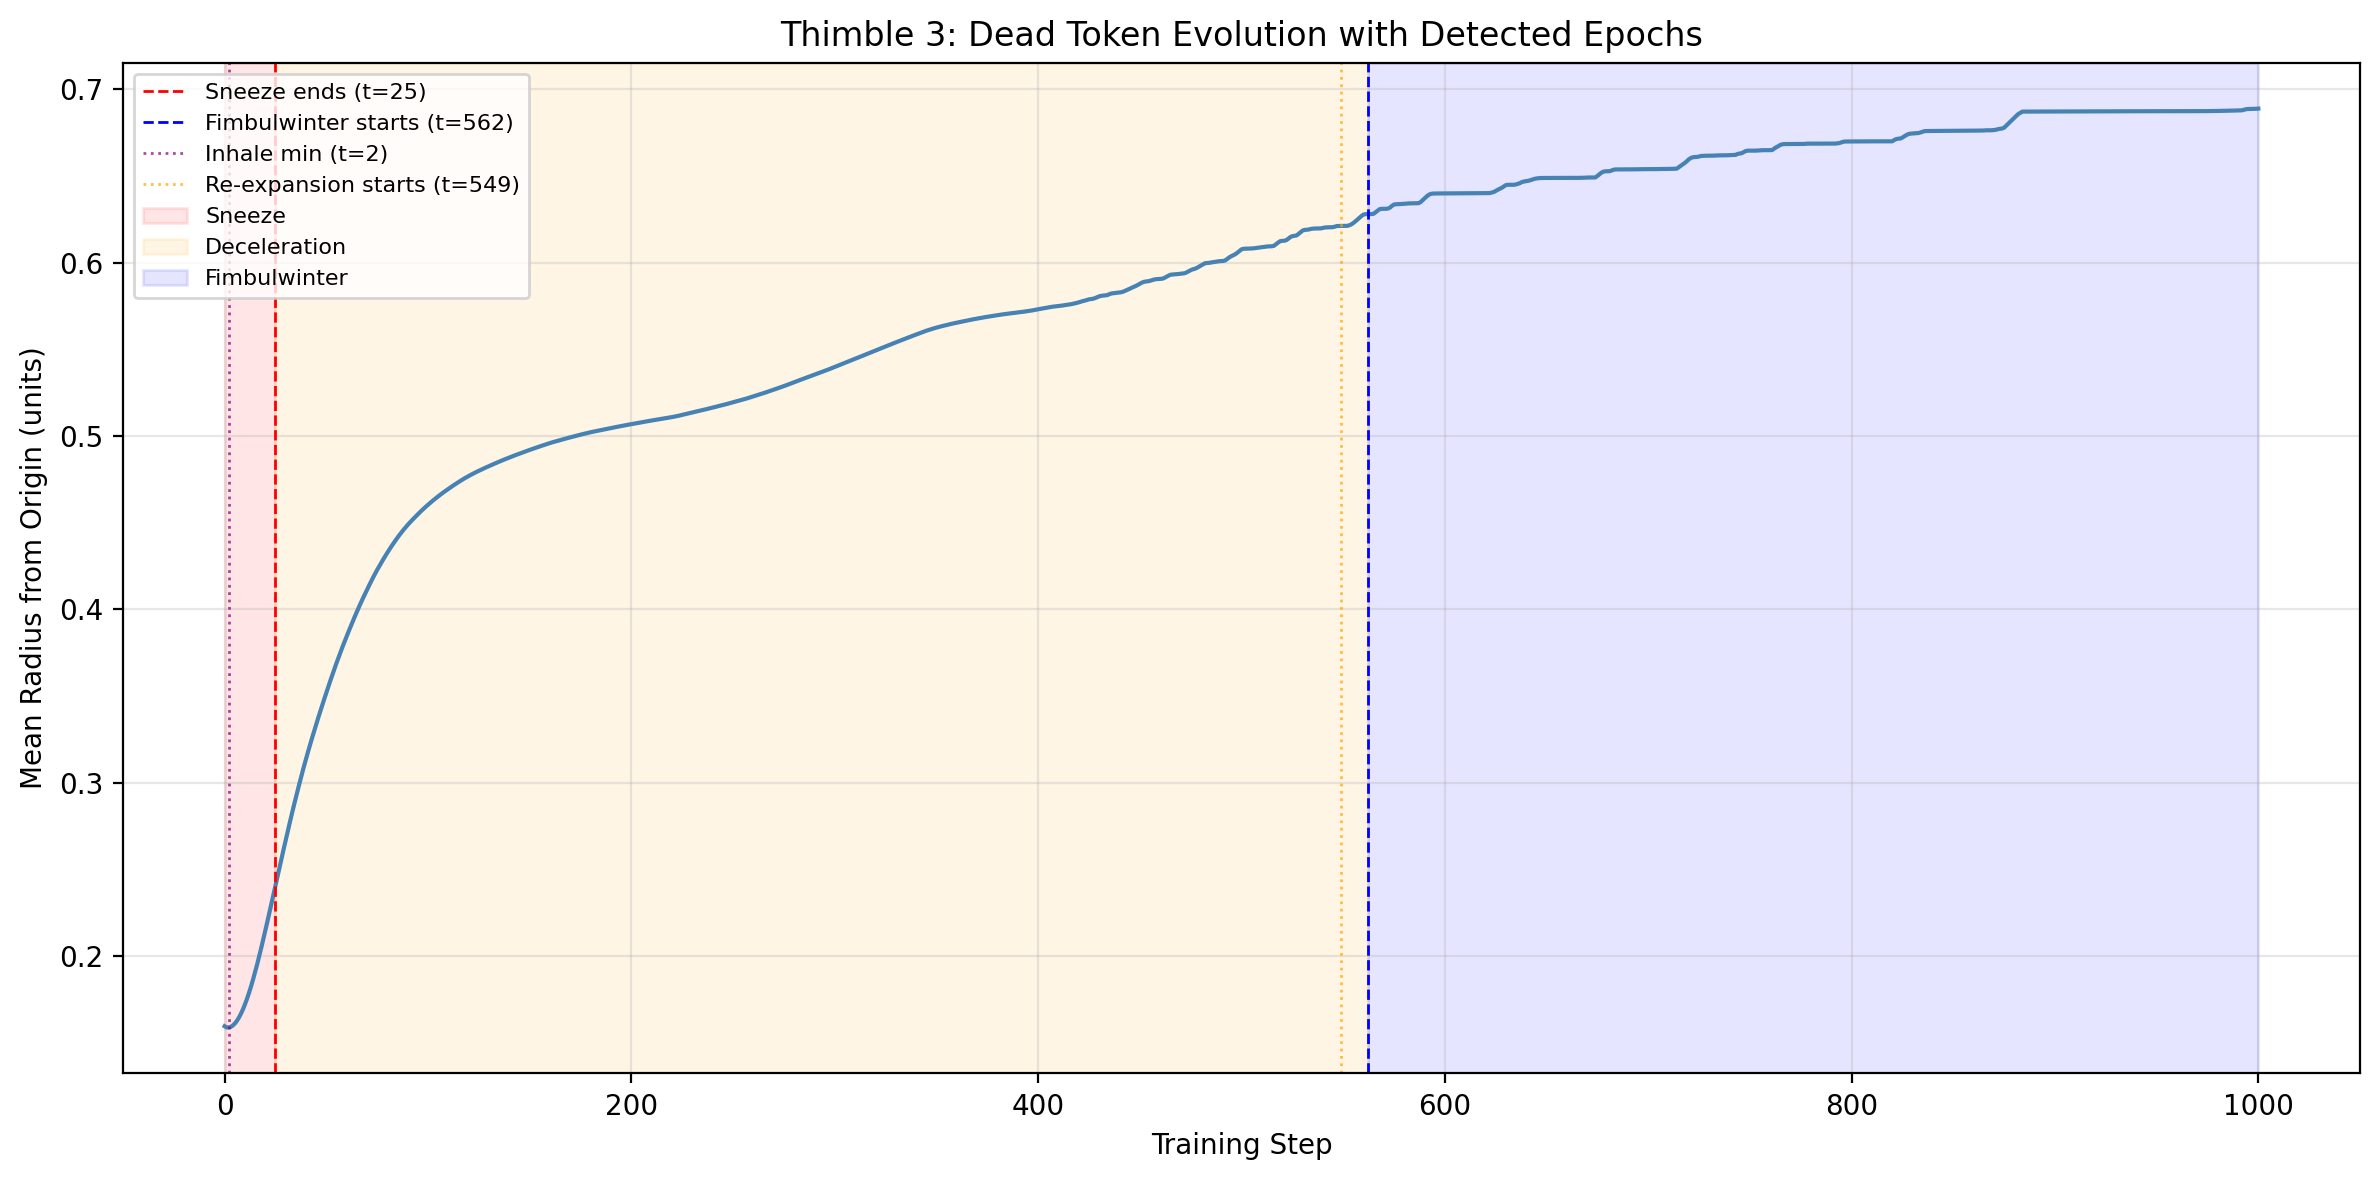

In [44]:
# Plot 1: Radius with detected boundaries
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

ax.plot(mean_radius.numpy(), linewidth=1.5, color='steelblue')

# Mark boundaries
ax.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, label=f'Sneeze ends (t={t_sneeze_end})')
ax.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, label=f'Fimbulwinter starts (t={t_fimbulwinter_start})')

# Mark optional features
if inhale_present:
    ax.axvline(t_inhale_min, color='purple', linestyle=':', linewidth=1, alpha=0.7, label=f'Inhale min (t={t_inhale_min})')

if reexpansion_present:
    ax.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7, label=f'Re-expansion starts (t={t_reexpansion_start})')

# Shade epochs
ax.axvspan(0, t_sneeze_end, alpha=0.1, color='red', label='Sneeze')
ax.axvspan(t_sneeze_end, t_fimbulwinter_start, alpha=0.1, color='orange', label='Deceleration')
ax.axvspan(t_fimbulwinter_start, len(mean_radius)-1, alpha=0.1, color='blue', label='Fimbulwinter')

ax.set_xlabel('Training Step')
ax.set_ylabel('Mean Radius from Origin (units)')
ax.set_title('Thimble 3: Dead Token Evolution with Detected Epochs')
ax.legend(loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

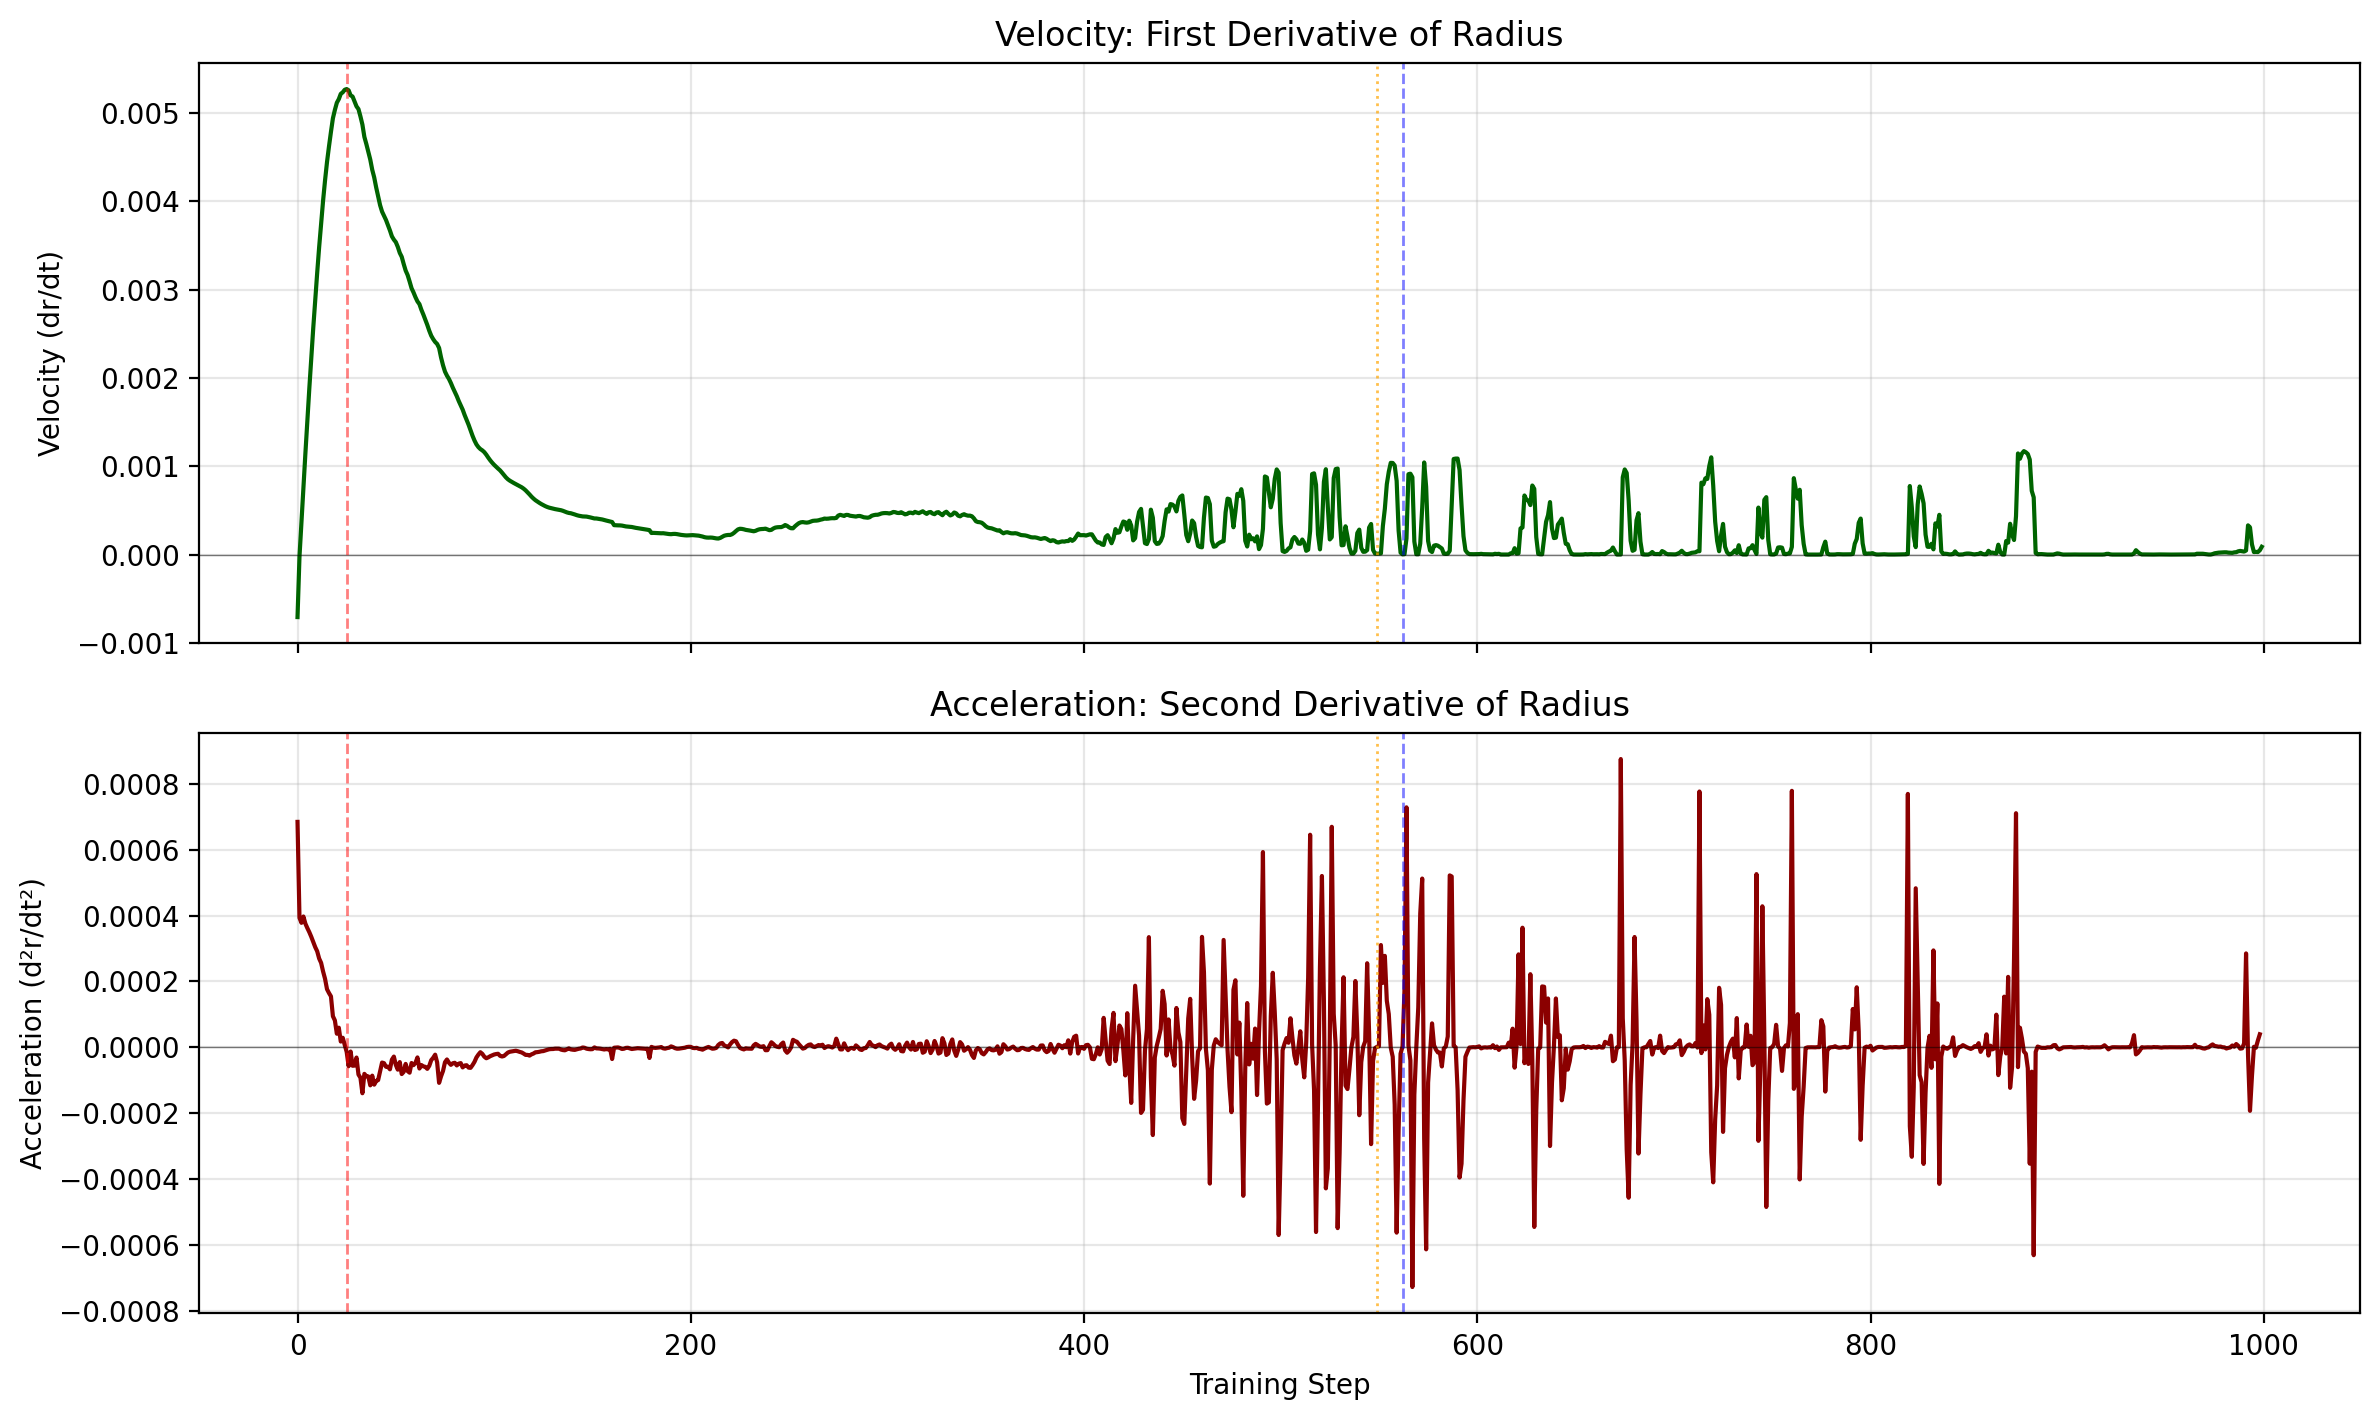

In [45]:
# Plot 2: Velocity and Acceleration
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(FIGSIZE[0], FIGSIZE[1]*1.2), dpi=DPI, sharex=True)

# Velocity
ax1.plot(velocity.numpy(), linewidth=1.5, color='darkgreen')
ax1.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax1.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax1.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, alpha=0.5)
if reexpansion_present:
    ax1.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax1.set_ylabel('Velocity (dr/dt)')
ax1.set_title('Velocity: First Derivative of Radius')
ax1.grid(True, alpha=0.3)

# Acceleration
ax2.plot(acceleration.numpy(), linewidth=1.5, color='darkred')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)
ax2.axvline(t_sneeze_end, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(t_fimbulwinter_start, color='blue', linestyle='--', linewidth=1, alpha=0.5)
if reexpansion_present:
    ax2.axvline(t_reexpansion_start, color='orange', linestyle=':', linewidth=1, alpha=0.7)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Acceleration (d²r/dt²)')
ax2.set_title('Acceleration: Second Derivative of Radius')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In [46]:
print("\n" + "="*80)
print("THIMBLE 3 EPOCH DETECTION SUMMARY")
print("="*80 + "\n")

print("Three Core Epochs:")
print(f"  1. The Sneeze:     t=0 → t={t_sneeze_end} ({t_sneeze_end} steps)")
print(f"  2. Deceleration:   t={t_sneeze_end} → t={t_fimbulwinter_start} ({t_fimbulwinter_start - t_sneeze_end} steps)")
print(f"  3. Fimbulwinter:   t={t_fimbulwinter_start} → t={len(mean_radius)-1} ({len(mean_radius) - 1 - t_fimbulwinter_start} steps)")
print()

print("Optional Features:")
if inhale_present:
    print(f"  ✓ Inhale detected at t={t_inhale_min} ({contraction*100:.2f}% contraction)")
else:
    print(f"  ✗ No inhale detected")

if reexpansion_present:
    print(f"  ✓ Re-expansion detected starting at t={t_reexpansion_start}")
else:
    print(f"  ✗ No re-expansion detected (monotonic deceleration)")

print()
print("Comparison to Flannel 7:")
print(f"  Flannel 7 Sneeze ended at t=27 (Thimble 3: t={t_sneeze_end})")
print(f"  Flannel 7 Fimbulwinter started at t=597 (Thimble 3: t={t_fimbulwinter_start})")

print("\n" + "="*80)
print("✓ Epoch detection complete.")
print("="*80)


THIMBLE 3 EPOCH DETECTION SUMMARY

Three Core Epochs:
  1. The Sneeze:     t=0 → t=25 (25 steps)
  2. Deceleration:   t=25 → t=562 (537 steps)
  3. Fimbulwinter:   t=562 → t=1000 (438 steps)

Optional Features:
  ✓ Inhale detected at t=2 (0.46% contraction)
  ✓ Re-expansion detected starting at t=549

Comparison to Flannel 7:
  Flannel 7 Sneeze ended at t=27 (Thimble 3: t=25)
  Flannel 7 Fimbulwinter started at t=597 (Thimble 3: t=562)

✓ Epoch detection complete.
